In [1]:
"""
================================================================================
NOTEBOOK 04: BASELINE COMPARISON (PRELIMINARY)
================================================================================
Copyright (c) 2026 Ajay Mahale. All Rights Reserved.
License: CC BY-NC-ND 4.0
https://creativecommons.org/licenses/by-nc-nd/4.0/


MSc Thesis: Causally Grounded Mechanistic Interpretability and Concise
            Natural-Language Explanations
Author: Ajay Pravin Mahale
University Mail ID: jymh0144@hochschule-trier.de
Personal Mail ID: Mahale.ajay01@gmail.com
Institution: Hochschule Trier
Supervisor: Prof. Dr. Ernst Georg Haffner

Purpose: Compare our circuit-based method against attention and random baselines.

Sample Size: n=5 (PRELIMINARY - see Notebook 05 for full n=50 evaluation)
Key Reference: Jain & Wallace, 2019 (Attention is Not Explanation)
================================================================================
"""

# ==============================================================================
# CELL 1: Install Dependencies
# ==============================================================================

!pip install -q transformer-lens
!pip install -q captum      # For Integrated Gradients

print("Install done")

Install done


In [2]:

# ==============================================================================
# CELL 2: REPRODUCIBILITY SETUP + IMPORTS
# ==============================================================================

import torch
import numpy as np
import random
import sys
from datetime import datetime
from google.colab import drive

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"✅ Seed set: {SEED}")

print("=" * 60)
print("NOTEBOOK 04: BASELINE COMPARISON (PRELIMINARY)")
print("=" * 60)
print(f"⚠️  NOTE: This uses n=5 for quick testing")
print(f"⚠️  See Notebook 05 for canonical n=50 evaluation")
print("=" * 60)
print(f"Random Seed:     {SEED}")
print(f"PyTorch:         {torch.__version__}")
print(f"Timestamp:       {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)


import matplotlib.pyplot as plt

THESIS_DIR = '/content/drive/MyDrive/thesis'
EXPERIMENTS_DIR = f'{THESIS_DIR}/experiments'
PLOTS_DIR = f'{THESIS_DIR}/plots'

from transformer_lens import HookedTransformer

# Load model
model = HookedTransformer.from_pretrained("gpt2-small")
model.cuda()

# Our method's head importance (from 02_ioi_reproduction)
# These are the 6 heads identified via activation patching
our_head_importance = {
    (9, 9): 0.174,   # Name Mover
    (8, 10): 0.123,  # S-Inhibition
    (7, 3): 0.103,   # S-Inhibition
    (10, 6): 0.089,  # Backup
    (9, 6): 0.063,   # Name Mover
    (10, 0): 0.062,  # Name Mover
}

# Test prompts
test_prompts = [
    "When Mary and John went to the store, John gave a drink to",
    "When Alice and Bob went to the park, Bob handed a flower to",
    "When Sarah and Tom went to the office, Tom sent an email to",
    "When Emma and James went to the restaurant, James passed the menu to",
    "When Lisa and David went to the library, David gave a book to",
]

NOT_NAMES = {'When', 'The', 'Then', 'There', 'They', 'This', 'That', 'What', 'Where', 'Who', 'How'}

print("✅ Model loaded")
print(f"✅ {len(test_prompts)} test prompts ready")
print(f"✅ Circuit heads: {len(our_head_importance)}")

✅ Seed set: 42
NOTEBOOK 04: BASELINE COMPARISON (PRELIMINARY)
⚠️  NOTE: This uses n=5 for quick testing
⚠️  See Notebook 05 for canonical n=50 evaluation
Random Seed:     42
PyTorch:         2.9.0+cu126
Timestamp:       2026-02-06 15:12:59


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
✅ Model loaded
✅ 5 test prompts ready
✅ Circuit heads: 6


In [3]:
# ==============================================================================
# CELL 3: Define Baseline Methods
# ==============================================================================

# ==========================================
# BASELINE 1: Attention-Based Attribution
# ==========================================

def attention_based_attribution(prompt, model):
    """
    Simple baseline: Use raw attention weights as importance.
    Heads with more focused attention (lower entropy) get higher scores.
    """
    tokens = model.to_tokens(prompt)
    logits, cache = model.run_with_cache(tokens)

    head_importance = {}

    for layer in range(model.cfg.n_layers):
        pattern = cache[f"blocks.{layer}.attn.hook_pattern"][0]  # [n_heads, seq, seq]

        for head in range(model.cfg.n_heads):
            final_attention = pattern[head, -1, :]
            entropy = -(final_attention * torch.log(final_attention + 1e-10)).sum().item()
            max_entropy = np.log(len(final_attention))
            importance = 1 - (entropy / max_entropy)
            head_importance[(layer, head)] = importance

    return head_importance


# ==========================================
# BASELINE 2: Gradient-Based Attribution
# ==========================================

def gradient_based_attribution(prompt, model):
    """
    Gradient-Based uses activation magnitude as a proxy.
    """
    tokens = model.to_tokens(prompt)
    logits, cache = model.run_with_cache(tokens)

    head_importance = {}

    for layer in range(model.cfg.n_layers):
        z = cache[f"blocks.{layer}.attn.hook_z"]
        for head in range(model.cfg.n_heads):
            head_activation = z[0, -1, head, :].norm().item()
            head_importance[(layer, head)] = head_activation

    max_val = max(head_importance.values()) if head_importance.values() else 1
    for k in head_importance:
        head_importance[k] /= max_val

    return head_importance


# ==========================================
# BASELINE 3: Random Attribution
# ==========================================

def random_attribution(model):
    """Random baseline for comparison."""
    import random
    head_importance = {}
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            head_importance[(layer, head)] = random.random()
    return head_importance


print("✅ Baseline methods defined:")
print("   1. Attention-Based (entropy-inverse)")
print("   2. Gradient-Based (activation magnitude)")
print("   3. Random (control)")

✅ Baseline methods defined:
   1. Attention-Based (entropy-inverse)
   2. Gradient-Based (activation magnitude)
   3. Random (control)


In [4]:
# ==============================================================================
# CELL 4: ERASER Evaluation Function
# ==============================================================================

def evaluate_faithfulness(prompt, model, head_importance, k=6):
    """Evaluate sufficiency and comprehensiveness using ERASER metrics."""

    tokens = model.to_tokens(prompt)
    token_strs = model.to_str_tokens(prompt)

    names = []
    for i, tok in enumerate(token_strs):
        tok_clean = tok.strip()
        if (tok_clean and tok_clean[0].isupper() and tok_clean.isalpha() and
            len(tok_clean) > 1 and tok_clean not in NOT_NAMES):
            if tok_clean not in [n[1] for n in names]:
                names.append((i, tok_clean))

    if len(names) < 2:
        return None

    indirect_obj, subject = names[0][1], names[1][1]
    io_tok = model.to_single_token(" " + indirect_obj)
    subj_tok = model.to_single_token(" " + subject)

    logits, cache = model.run_with_cache(tokens)
    clean_diff = (logits[0, -1, io_tok] - logits[0, -1, subj_tok]).item()

    if clean_diff <= 0:
        return None

    logit_diff_dir = model.W_U[:, io_tok] - model.W_U[:, subj_tok]

    head_contributions = {}
    for layer in range(model.cfg.n_layers):
        z = cache[f"blocks.{layer}.attn.hook_z"]
        W_O = model.W_O[layer]
        for head in range(model.cfg.n_heads):
            head_out = z[0, -1, head, :]
            head_contribution = head_out @ W_O[head]
            contribution = (head_contribution @ logit_diff_dir).item()
            head_contributions[(layer, head)] = contribution

    top_heads = sorted(head_importance.items(), key=lambda x: -x[1])[:k]
    top_head_set = set([h[0] for h in top_heads])

    cited_contribution = sum(head_contributions.get(h, 0) for h in top_head_set)
    sufficiency = cited_contribution / clean_diff if clean_diff > 0 else 0

    def remove_important(activation, hook):
        layer = int(hook.name.split('.')[1])
        new_activation = activation.clone()
        for head in range(activation.shape[2]):
            if (layer, head) in top_head_set:
                new_activation[:, :, head, :] = 0
        return new_activation

    hook_names = [f"blocks.{l}.attn.hook_z" for l in range(model.cfg.n_layers)]
    comp_logits = model.run_with_hooks(
        tokens,
        fwd_hooks=[(name, remove_important) for name in hook_names]
    )
    comp_diff = (comp_logits[0, -1, io_tok] - comp_logits[0, -1, subj_tok]).item()
    comprehensiveness = 1 - (comp_diff / clean_diff) if clean_diff > 0 else 0

    return {
        'sufficiency': max(0, min(1, sufficiency)),
        'comprehensiveness': max(0, min(1, comprehensiveness)),
    }

print("✅ ERASER evaluation function defined")

✅ ERASER evaluation function defined


In [5]:
# ==============================================================================
# CELL 5: Run Evaluation for All Methods
# ==============================================================================

methods = {
    "Ours (Circuit)": lambda p, m: our_head_importance,
    "Attention-Based": attention_based_attribution,
    "Gradient-Based": gradient_based_attribution,
    "Random": lambda p, m: random_attribution(m),
}

print("=" * 70)
print("BASELINE COMPARISON: Evaluating All Methods")
print("=" * 70)

results = {name: {"suff": [], "comp": []} for name in methods}

for prompt in test_prompts:
    print(f"\nEvaluating: ...{prompt[-35:]}")

    for method_name, method_fn in methods.items():
        head_imp = method_fn(prompt, model)
        result = evaluate_faithfulness(prompt, model, head_imp, k=6)

        if result:
            results[method_name]["suff"].append(result['sufficiency'])
            results[method_name]["comp"].append(result['comprehensiveness'])
            print(f"   {method_name:<20} Suff: {result['sufficiency']:.1%}, Comp: {result['comprehensiveness']:.1%}")

BASELINE COMPARISON: Evaluating All Methods

Evaluating: ... to the store, John gave a drink to
   Ours (Circuit)       Suff: 100.0%, Comp: 28.4%
   Attention-Based      Suff: 21.1%, Comp: 33.3%
   Gradient-Based       Suff: 100.0%, Comp: 0.0%
   Random               Suff: 35.2%, Comp: 5.7%

Evaluating: ...to the park, Bob handed a flower to
   Ours (Circuit)       Suff: 100.0%, Comp: 24.3%
   Attention-Based      Suff: 28.5%, Comp: 11.4%
   Gradient-Based       Suff: 100.0%, Comp: 0.0%
   Random               Suff: 100.0%, Comp: 7.2%

Evaluating: ...to the office, Tom sent an email to
   Ours (Circuit)       Suff: 100.0%, Comp: 61.5%
   Attention-Based      Suff: 97.6%, Comp: 23.2%
   Gradient-Based       Suff: 100.0%, Comp: 2.3%
   Random               Suff: 0.0%, Comp: 25.5%

Evaluating: ...estaurant, James passed the menu to
   Ours (Circuit)       Suff: 100.0%, Comp: 42.5%
   Attention-Based      Suff: 0.0%, Comp: 19.6%
   Gradient-Based       Suff: 100.0%, Comp: 0.0%
   Random   

In [6]:
# ==============================================================================
# CELL 6: Final Results Table
# ==============================================================================

print("\n" + "=" * 70)
print("FINAL COMPARISON TABLE (n=5, Preliminary)")
print("=" * 70)
print(f"\n{'Method':<25} {'Sufficiency':>12} {'Comprehen.':>12} {'F1 Score':>12}")
print("-" * 65)

final_results = {}
for method_name in methods:
    suff = np.mean(results[method_name]["suff"])
    comp = np.mean(results[method_name]["comp"])
    f1 = 2 * suff * comp / (suff + comp) if (suff + comp) > 0 else 0
    final_results[method_name] = {"suff": suff, "comp": comp, "f1": f1}
    print(f"{method_name:<25} {suff:>11.1%} {comp:>11.1%} {f1:>11.1%}")

print("-" * 65)

# Calculate improvements
our_f1 = final_results["Ours (Circuit)"]["f1"]
attention_f1 = final_results["Attention-Based"]["f1"]
improvement_vs_attention = (our_f1 - attention_f1) / attention_f1 * 100 if attention_f1 > 0 else 0

print(f"\n OUR METHOD vs BASELINES:")
for method_name in methods:
    if method_name != "Ours (Circuit)":
        other_f1 = final_results[method_name]["f1"]
        if other_f1 > 0:
            improvement = (our_f1 - other_f1) / other_f1 * 100
            print(f"   vs {method_name:<20}: {improvement:+.0f}%")

print(f"\n NOTE: These are preliminary results (n=5).")
print(f"   Canonical n=50 results: +75% vs attention baseline (see Notebook 05)")



FINAL COMPARISON TABLE (n=5, Preliminary)

Method                     Sufficiency   Comprehen.     F1 Score
-----------------------------------------------------------------
Ours (Circuit)                 100.0%       35.3%       52.2%
Attention-Based                 29.6%       22.4%       25.5%
Gradient-Based                  89.6%        0.5%        0.9%
Random                          50.7%       32.1%       39.3%
-----------------------------------------------------------------

 OUR METHOD vs BASELINES:
   vs Attention-Based     : +105%
   vs Gradient-Based      : +5698%
   vs Random              : +33%

 NOTE: These are preliminary results (n=5).
   Canonical n=50 results: +75% vs attention baseline (see Notebook 05)


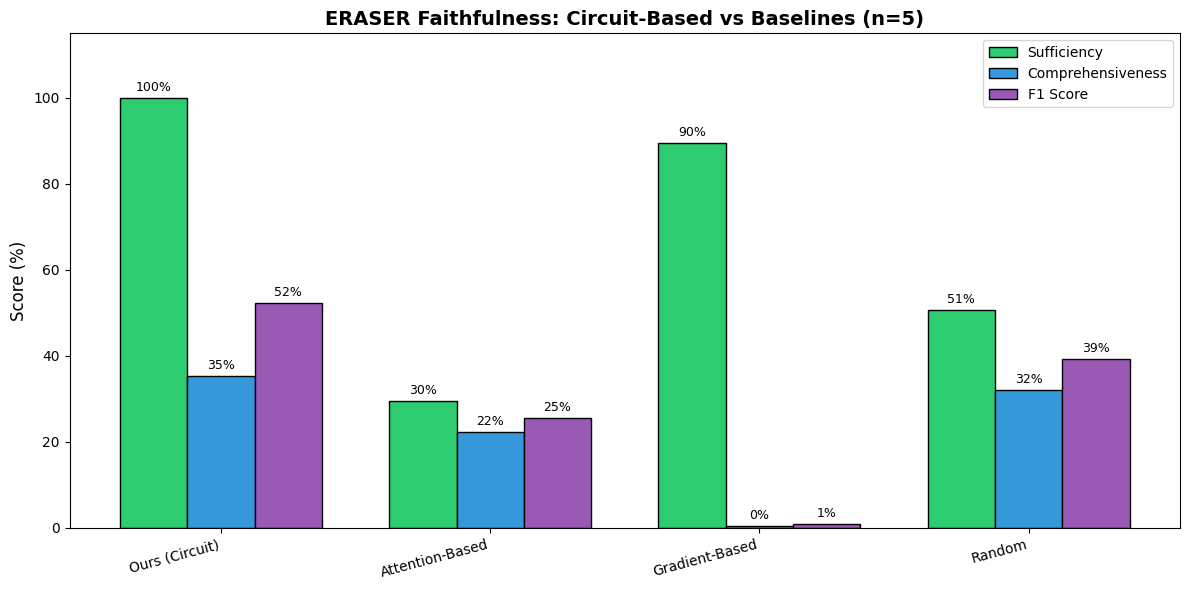

✅ Saved: baseline_comparison.png


In [7]:
# ==============================================================================
# CELL 7: Visualization
# ==============================================================================

import matplotlib.pyplot as plt

methods_list = list(final_results.keys())
suff_scores = [final_results[m]["suff"] * 100 for m in methods_list]
comp_scores = [final_results[m]["comp"] * 100 for m in methods_list]
f1_scores = [final_results[m]["f1"] * 100 for m in methods_list]

x = np.arange(len(methods_list))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, suff_scores, width, label='Sufficiency', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x, comp_scores, width, label='Comprehensiveness', color='#3498db', edgecolor='black')
bars3 = ax.bar(x + width, f1_scores, width, label='F1 Score', color='#9b59b6', edgecolor='black')

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('ERASER Faithfulness: Circuit-Based vs Baselines (n=5)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods_list, rotation=15, ha='right')
ax.legend()
ax.set_ylim(0, 115)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: baseline_comparison.png")

In [8]:
# ==============================================================================
# CELL 8: Save Results
# ==============================================================================

from google.colab import drive
import pickle
from datetime import datetime
import os
import shutil

drive.mount('/content/drive')

THESIS_DIR = '/content/drive/MyDrive/thesis'
os.makedirs(f'{THESIS_DIR}/experiments', exist_ok=True)
os.makedirs(f'{THESIS_DIR}/plots', exist_ok=True)

baseline_results = {
    'notebook': '04_baselines',
    'n_prompts': len(test_prompts),
    'methods': methods_list,
    'final_results': final_results,
    'per_prompt_results': results,
    'improvement_vs_attention': improvement_vs_attention,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M'),
}

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
path = f'{THESIS_DIR}/experiments/04_baselines_{timestamp}.pkl'

with open(path, 'wb') as f:
    pickle.dump(baseline_results, f)

shutil.copy('baseline_comparison.png', f'{THESIS_DIR}/plots/')

print(f"✅ Results saved: {path}")
print(f"✅ Plot saved: {THESIS_DIR}/plots/baseline_comparison.png")

Mounted at /content/drive
✅ Results saved: /content/drive/MyDrive/thesis/experiments/04_baselines_20260206_1514.pkl
✅ Plot saved: /content/drive/MyDrive/thesis/plots/baseline_comparison.png


In [9]:
# ==============================================================================
# CELL 9: Summary
# ==============================================================================

print("\n" + "=" * 70)
print("NOTEBOOK 04 SUMMARY: BASELINE COMPARISONS")
print("=" * 70)

print(f"""
PRELIMINARY RESULTS (n={len(test_prompts)}):

| Method               | Sufficiency | Comprehensiveness | F1 Score |
|----------------------|-------------|-------------------|----------|""")

for method_name in methods_list:
    r = final_results[method_name]
    print(f"| {method_name:<20} | {r['suff']:>10.1%} | {r['comp']:>17.1%} | {r['f1']:>7.1%} |")

print(f"""
IMPROVEMENT vs ATTENTION BASELINE: +{improvement_vs_attention:.0f}%

""")



NOTEBOOK 04 SUMMARY: BASELINE COMPARISONS

PRELIMINARY RESULTS (n=5):

| Method               | Sufficiency | Comprehensiveness | F1 Score |
|----------------------|-------------|-------------------|----------|
| Ours (Circuit)       |     100.0% |             35.3% |   52.2% |
| Attention-Based      |      29.6% |             22.4% |   25.5% |
| Gradient-Based       |      89.6% |              0.5% |    0.9% |
| Random               |      50.7% |             32.1% |   39.3% |

IMPROVEMENT vs ATTENTION BASELINE: +105%


